**Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
from tqdm import tqdm
from tensorflow.keras.models import *
import cv2
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Input,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam|
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.applications import MobileNetV2,MobileNet,MobileNetV3Small
from keras.preprocessing.image import load_img

**Loading Datasets**

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
path2train  = '/content/drive/MyDrive/Final year project/Untitled folder/My Dataset/train'
path2test  = '/content/drive/MyDrive/Final year project/Untitled folder/My Dataset/test'

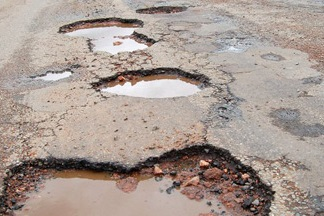

In [6]:
pothole_eg = load_img(path2train + "/Pothole/1.jpg")
pothole_eg

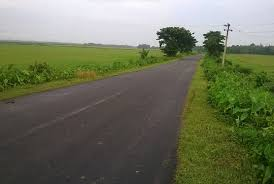

In [7]:
plain_eg = load_img(path2train + '/Plain/11.jpg')
plain_eg

**Preprocessing**

In [8]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32
image_size = (128,128)

In [9]:
train_generator = ImageDataGenerator(
    rescale = 1.0/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
)
test_generator = ImageDataGenerator(rescale=1./255.)

In [11]:
train_datagen = train_generator.flow_from_directory(
    path2train,
    batch_size=10,
    target_size=(224, 224)
)
test_datagen = test_generator.flow_from_directory(
    path2test,
    batch_size=10,
    target_size=(224, 224)
)

Found 723 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


**MobilenetV2 Model**

In [12]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_mob = Model(inputs=base_model.input, outputs=predictions)

17225924/17225924 [==============================] - 0s 0us/step


In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

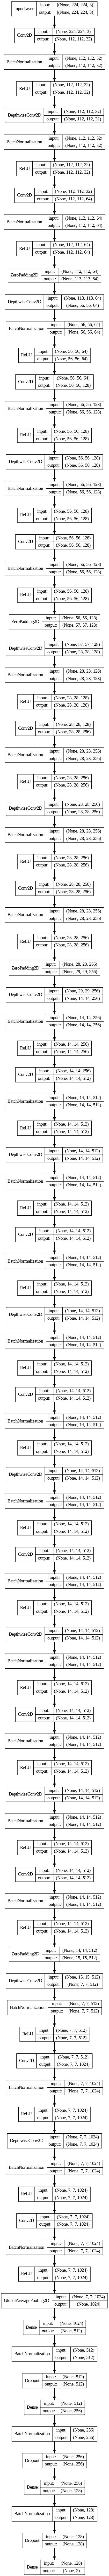

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model_mob, expand_nested=True, show_shapes=True, show_layer_names=False)

**Compiling Model**

In [15]:
model_mob.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Training Model**

In [16]:
hist_mob = model_mob.fit(train_datagen, epochs=10, validation_data=test_datagen,callbacks=[reduce_lr])

Epoch 1/10
73/73 [==============================] - 138s 2s/step - loss: 0.4498 - accuracy: 0.8230 - val_loss: 0.5443 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/10
73/73 [==============================] - 44s 601ms/step - loss: 0.3172 - accuracy: 0.8907 - val_loss: 0.6046 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/10
73/73 [==============================] - 62s 836ms/step - loss: 0.2271 - accuracy: 0.9198 - val_loss: 0.6958 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/10
73/73 [==============================] - 47s 647ms/step - loss: 0.1879 - accuracy: 0.9419 - val_loss: 0.5434 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/10
73/73 [==============================] - 52s 702ms/step - loss: 0.1559 - accuracy: 0.9433 - val_loss: 0.6389 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
73/73 [==============================] - 50s 678ms/step - loss: 0.1383 - accuracy: 0.9640 - val_loss: 0.5677 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/10
73/73 [==============================] - 43s 600ms/step

**Validation accuracy, loss and learning rate**

In [17]:
train_accuracy = hist_mob.history['accuracy']
val_accuracy = hist_mob.history['val_accuracy']

train_loss = hist_mob.history['loss']
val_loss = hist_mob.history['val_loss']

learning_rate = hist_mob.history['lr']

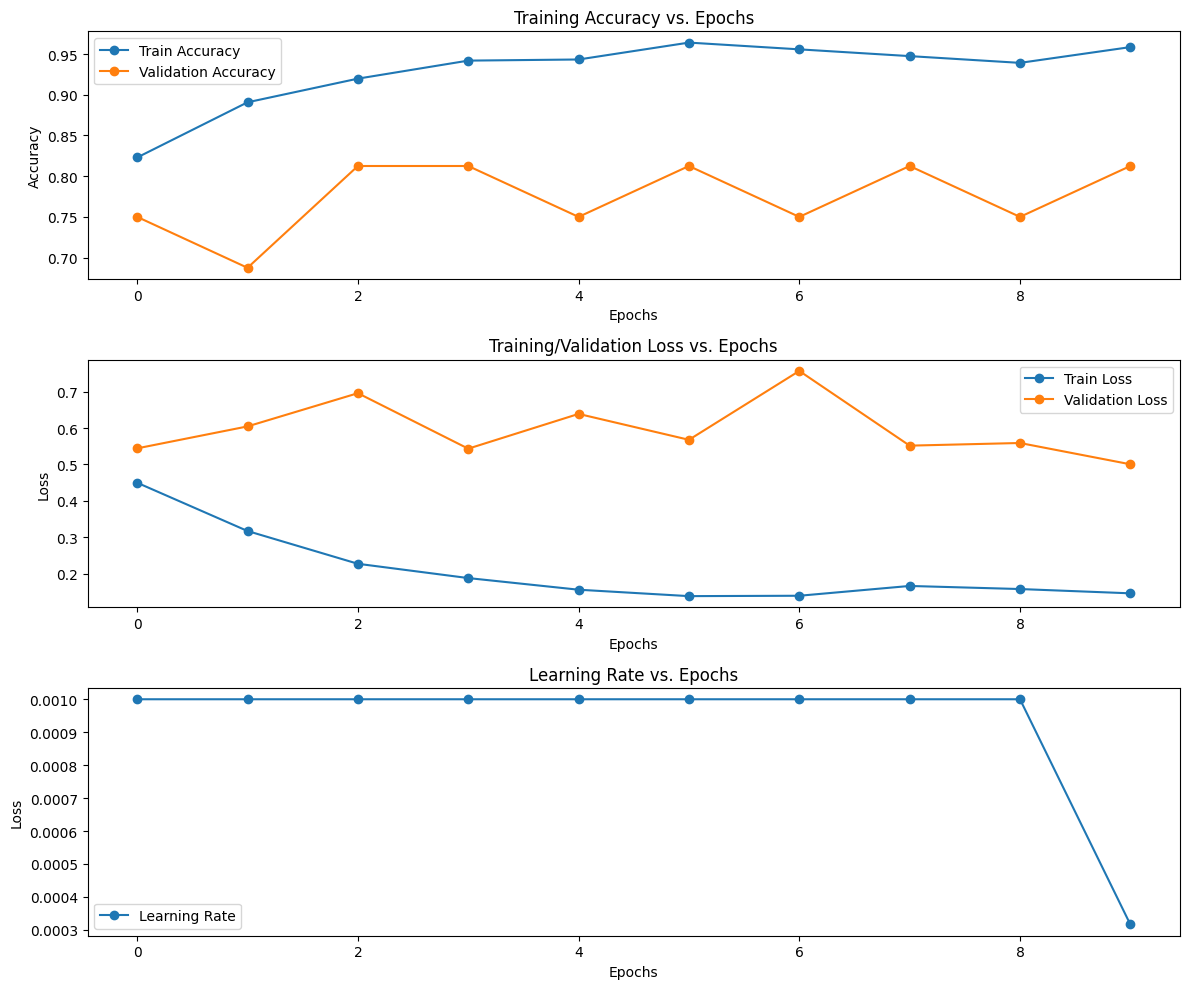

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

**Testing the Model**

In [19]:
test_dataset = '/content/drive/MyDrive/Final year project/Untitled folder/My Dataset/test'

In [20]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 16 images belonging to 2 classes.


**Model Prediction**

In [22]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(path2train,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 723 images belonging to 2 classes.


In [23]:
labels = {value: key for key, value in train_generator.class_indices.items()}

In [24]:
predictions = model_mob.predict(test_generator)

1/1 [==============================] - 1s 1s/step


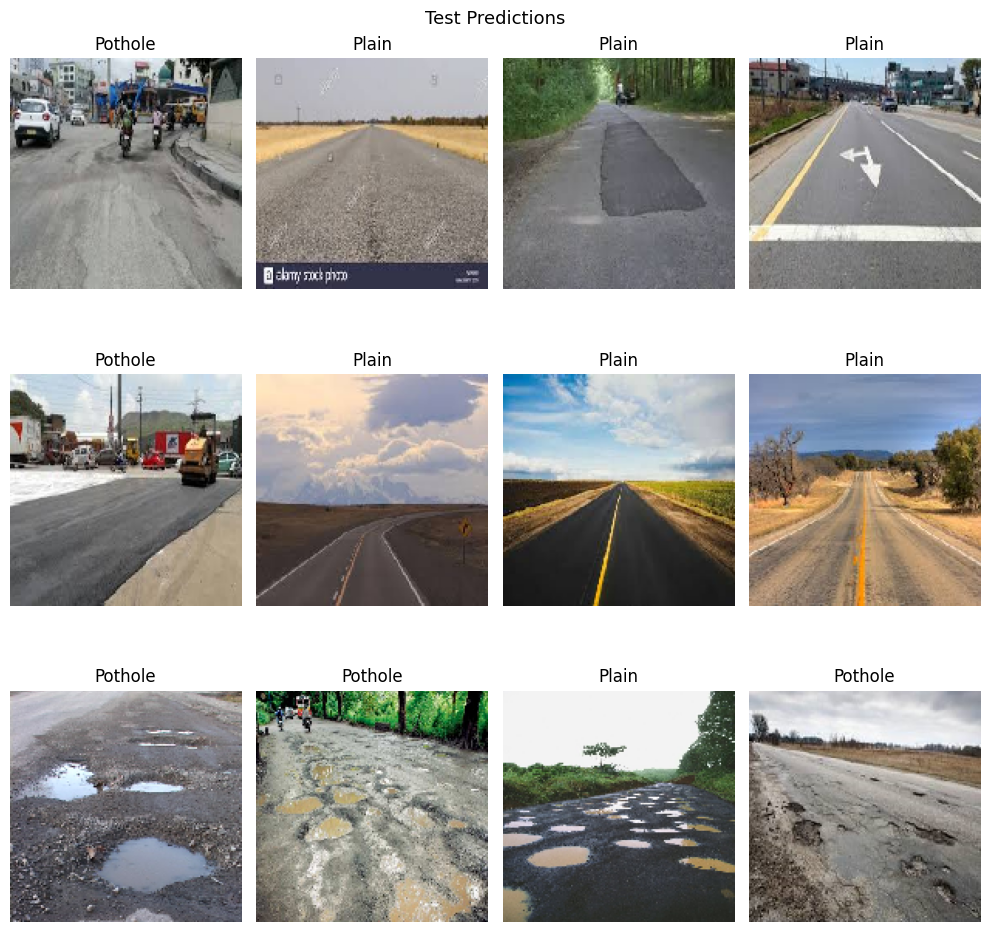

In [55]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 10))
idx = 0

for i in range(3):
    for j in range(4):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Predictions", fontsize=13)
plt.show()

In [26]:
test_loss, test_accuracy = model_mob.evaluate(test_generator, batch_size=BATCH_SIZE)

1/1 [==============================] - 0s 306ms/step - loss: 0.4911 - accuracy: 0.8125


In [27]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.49111708998680115
Test Accuracy: 0.8125


**Confusion Matrix**

In [28]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

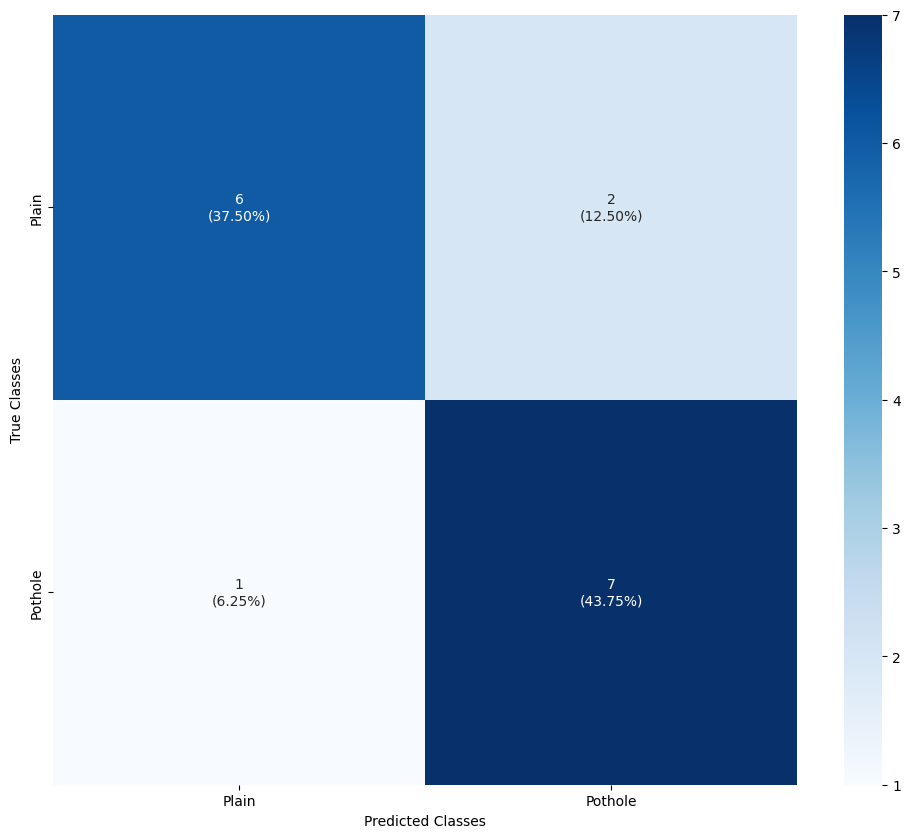

In [29]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="Blues", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [30]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

       Plain       0.86      0.75      0.80         8
     Pothole       0.78      0.88      0.82         8

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.82      0.81      0.81        16



In [31]:
tf.keras.models.save_model(model_mob,'my_model.hdf5')

In [36]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00


In [37]:
%%writefile app.py

Overwriting app.py


In [43]:
import __main__ as main
main.__file__ = "main_file"

In [44]:
import streamlit as st
import tensorflow as tf
import streamlit as st

@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])

2024-02-21 23:19:44.442 `st.cache` is deprecated. Please use one of Streamlit's new caching commands,
`st.cache_data` or `st.cache_resource`.

More information [in our docs](https://docs.streamlit.io/library/advanced-features/caching).


In [45]:
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):

        size = (128,128)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.

        img_reshape = img[np.newaxis,...]

        prediction = model.predict(img_reshape)

        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

2024-02-21 23:19:49.628 
════════════════════════════════════════════════
deprecation.showfileUploaderEncoding IS NO LONGER SUPPORTED.

deprecation.showfileUploaderEncoding has been deprecated and will be removed in a future version.

Please update <user defined>.
════════════════════════════════════════════════

